# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**

Проведите исследовательский анализ набора фотографий. Сделайте выводы о том, как результаты исследования повлияют на обучение модели. Этапы анализа:
- Посмотрите на размер выборки.
- Постройте график распределения возраста в выборке.
- Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

# Библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import math

# Исследовательский анализ данных

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
median = data['real_age'].median()

In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


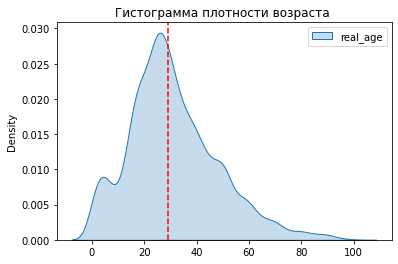

In [7]:
sns.kdeplot(data=data,fill=True)
plt.axvline(median, color='red', linestyle='--')
plt.title('Гистограмма плотности возраста ')
plt.show()

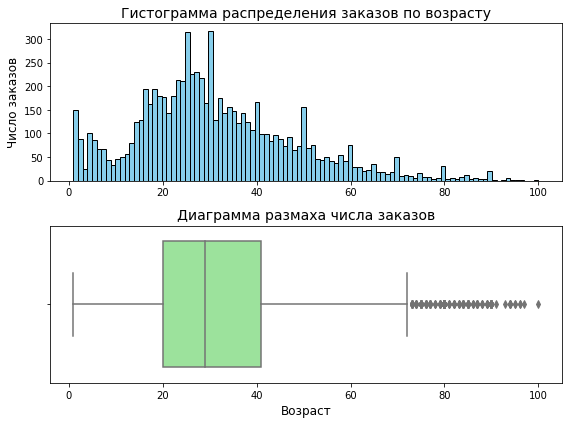

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Гистограмма
ax1.hist(data['real_age'], bins=100, color='skyblue', edgecolor='black')
ax1.set_title('Гистограмма распределения заказов по возрасту', fontsize=14)
ax1.set_ylabel('Число заказов', fontsize=12)
ax1.set_xticks(range(0, 101, 20))

# Диаграмма размаха
sns.boxplot(x='real_age', data=data, color='lightgreen', ax=ax2)
ax2.set_title('Диаграмма размаха числа заказов', fontsize=14)
ax2.set_xlabel('Возраст', fontsize=12)
ax2.set_xticks(range(0, 101, 20))

plt.tight_layout()
plt.show()

In [9]:
def cat(x):
     if 6<=x<25:
        return 'юношеский'
     elif 25<=x<44:
        return 'молодой'
     elif 44<=x<60 :
        return 'средний' 
     elif x>=60 :
        return 'пожилой' 

In [10]:
data_filt = data.copy()

In [11]:
data_filt['категории'] = data_filt['real_age'].apply(cat)

In [12]:
data_filt

,file_name,real_age,категории
0,000000.jpg,4,None
1,000001.jpg,18,юношеский
2,000002.jpg,80,пожилой
3,000003.jpg,50,средний
4,000004.jpg,17,юношеский
...,...,...,...
7586,007608.jpg,14,юношеский
7587,007609.jpg,37,молодой
7588,007610.jpg,28,молодой
7589,007611.jpg,20,юношеский


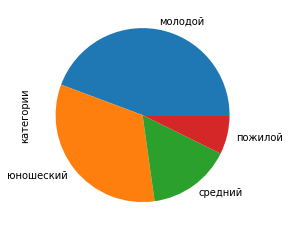

In [13]:
data_filt['категории'].value_counts().plot(kind='pie')
plt.show()

In [14]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_train_flow = datagen.flow_from_dataframe(
    data_filt,
    '/datasets/faces/final_files/',
    x_col="file_name",
    y_col="real_age",
    class_mode='raw',
    subset='training',
    seed=12345,
    verbose=1)

Found 7591 validated image filenames.


In [15]:
train_data , y_train = next(datagen_train_flow)

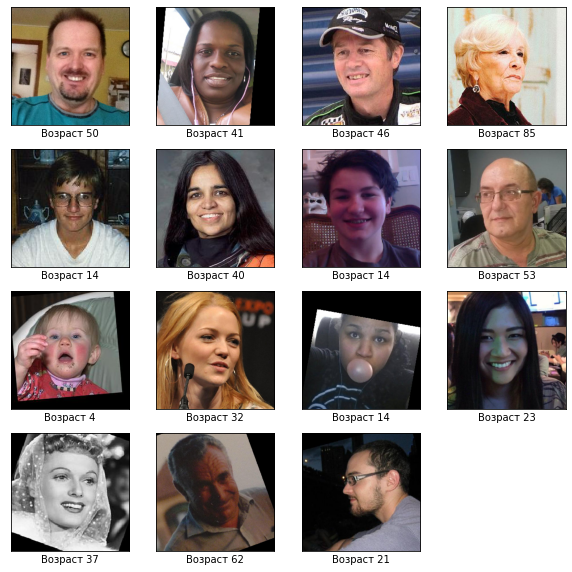

In [16]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4,4,i+1)
    plt.imshow(train_data[i])
    plt.xlabel(f'Возраст {y_train[i]}')
    plt.xticks([])
    plt.yticks([])
#     plt.tight_layout()

Вывод:
- Количество 7591 фотографий 
- Пропусков нет, тип данных корректные
- Средний возраст 31, медиана 29.
- Распределение возраста нормальное со смещением вправо 
- Фотографии хранятся в формате `jpg`, с тремя цветовыми каналми `RGB`
- Предобработанный датасет содержит лица находящиеся в центре изображения под разным ракурсом, цветные и черно-белые
- Часть фотографий содержит черные полосы по краям, оставшиеся после обрезки и поворота
- Данные размечены верно и приблизительно соотвествуют возрасту

# Обучение 

In [17]:
def load_train(path):

    data = pd.read_csv(path+'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25,
                                    rescale=1/255.,
                                    horizontal_flip=True,
                                    rotation_range =90,
                                    zoom_range=0.2,
                                    height_shift_range=0.2,
                                    width_shift_range=0.2)
    
    datagen_train_flow = datagen.flow_from_dataframe(
        data,
        path+'/final_files',
        target_size=(224, 224),
        x_col="file_name",
        y_col="real_age",
        # batch_size=16,
        class_mode='raw',
        subset='training',
        seed=1234
        )

    return datagen_train_flow

def load_test(path):

    data = pd.read_csv(path+'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25,
                                    rescale=1/255.
                                    )
    test_flow = datagen.flow_from_dataframe(
        data,
        path+'/final_files',
        target_size=(224, 224),
        x_col="file_name",
        y_col="real_age",
        # batch_size=16,
        class_mode='raw',
        shuffle=True,
        subset='validation',
        seed=1234
        )

    return test_flow

def create_model(input_shape):

    optimizer = Adam(learning_rate=0.0001) 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False
                    ) 
    # backbone.trainable = False    
    for layer in backbone.layers[-20:]:
        layer.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(64, activation='relu')) 
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer,   
                    loss='mse', 
                    metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    callbacks = [
    EarlyStopping(monitor='val_mae', patience=5, mode='max'),
    ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=2, mode='max')
]

    model.fit(train_data,
                validation_data=test_data,
                batch_size=batch_size,
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                verbose=2,
                callbacks=callbacks)

    return model

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/15
2025-05-14 11:23:27.942367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-14 11:23:28.733085: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 165s - loss: 297.7563 - mae: 12.7849 - val_loss: 1033.2979 - val_mae: 27.4073

Epoch 2/15
178/178 - 111s - loss: 136.1562 - mae: 8.8687 - val_loss: 941.3743 - val_mae: 25.7517

Epoch 3/15
178/178 - 117s - loss: 115.5317 - mae: 8.1653 - val_loss: 367.6210 - val_mae: 14.1437

Epoch 4/15
178/178 - 117s - loss: 94.5577 - mae: 7.4219 - val_loss: 133.1193 - val_mae: 8.6795

Epoch 5/15
178/178 - 117s - loss: 86.7854 - mae: 7.0759 - val_loss: 94.4765 - val_mae: 7.3833

Epoch 6/15
178/178 - 116s - loss: 81.5485 - mae: 6.9170 - val_loss: 83.3119 - val_mae: 6.9339
WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
60/60 - 12s - loss: 83.3119 - mae: 6.9339

Вывод MAE на тренировочной 7 на тестовой 7

# Итог

- Количество 7591 фотографий 
- Пропусков нет, тип данных корректные
- Средний возраст 31, медиана 29.
- Распределение возраста нормальное со смещением вправо 
- Фотографии хранятся в формате `jpg`, с тремя цветовыми каналми `RGB`
- Предобработанный датасет содержит лица находящиеся в центре изображения под разным ракурсом, цветные и черно-белые
- Часть фотографий содержит черные полосы по краям, оставшиеся после обрезки и поворота
- Данные размечены верно и приблизительно соотвествуют возрасту

Использовалась модель ResNet50 с добавленными слояви GlobalAveragePooling2D и Dense(1 нейрон с активацией `relu`). 
- Для улучшения качества разблокированы последние 20 слоев, остальные слои предобученные
- Размер батча 16, количество эпох 15
- Оптимизатор Adam с параметром lr = 0.0001, для ускорения использовалсь функция потерь MSE
- Коллбэки для ранней остановки
 - EarlyStopping(monitor='val_mae', patience=5, mode='max'),
 - ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=2, mode='max')
- Получена метрика  MAE на 6 эпохи тренировочной =  6.9170 и тестовой выборки =  6.9339 , что выше необходимого критерия меньше 8 на тестовой выборке

Модель соотвествует необходимым критериям для решения проблемы. Для дальнейшего улучшения модели можно увеличить время обучения или поиск дополнительных параметров. Также провести болле детальный анализ и фильтрацию датасета, в нем есть некорректные данные возрастов.